# IMPORT PACKAGES
---


In [1]:
import pandas as pd 
import numpy as np
import joblib
import spacy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 

from bs4 import BeautifulSoup
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tensorflow import keras

import nltk
from nltk.corpus import stopwords

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models import FastText
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

print(" setup complete")

 setup complete


# LOAD DATA
---


In [7]:
df_questions = pd.read_csv('../../data/Questions.csv', encoding = "ISO-8859-1", nrows=30000, usecols=['Id', 'Title', 'Score','Body'])
df_questions.shape

(30000, 4)

In [8]:
df_questions.head(10)

,Id,Score,Title,Body
0,469,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...
5,742,30,Class views in Django,"<p><a href=""http://www.djangoproject.com/"">Dja..."
6,766,20,Python and MySQL,<p>I can get Python to work with Postgresql bu...
7,773,256,How do I use Python's itertools.groupby()?,<p>I haven't been able to find an understandab...
8,972,364,Adding a Method to an Existing Object Instance,<p>I've read that it is possible to add a meth...
9,1476,251,How do you express binary literals in Python?,<p>How do you express an integer as a binary n...


In [9]:
print('Title 1 : ', df_questions.iloc[0, 2])
print('Question 1 : ', df_questions.iloc[0, 3])

print('Title 2 : ', df_questions.iloc[1, 2])
print('Question 2 : ', df_questions.iloc[1, 3])

print('Title 3 : ', df_questions.iloc[2, 2])
print('Question 3 : ', df_questions.iloc[2, 3])

print('Title 4 : ', df_questions.iloc[3, 2])
print('Question 4 : ', df_questions.iloc[3, 3])

print('Title 5 : ', df_questions.iloc[4, 2])
print('Question 5 : ', df_questions.iloc[4, 3])


Title 1 :  How can I find the full path to a font from its display name on a Mac?
Question 1 :  <p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>

<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>

<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>

<ul>
<li>Some Photoshop javascript</li>
<li>A Python function</li>
<li>An OSX API that I can call from python</li>
</ul>

Title 2 :  Get a preview JPEG of a PDF on Windows?
Question 2 :  <p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>

<p>On the Mac I am spawning <a href="http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html">sips</a>.  Is there something similarly simple I can do on Windows?</p>

Title 3 :  Continuous Integration System for a Python Codebase
Question 3 :  <

# PREPROCESSING
---
from bs4 import BeautifulSoup
- --> grab the inside 'p'
- --> concatenate the text 

In [10]:
def get_question(html_text):
  soup = BeautifulSoup(html_text, 'lxml')
  question = ' '.join([t.text for t in soup.find_all('p')])
  return question

#Transforming questions to list for ease of processing
question_list = df_questions['Body'].apply(get_question).values.tolist()

In [11]:
question_list[0]

"I am using the Photoshop's javascript API to find the fonts in a given PSD. Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc. This is all happening in a python program running on OSX so I guess I'm looking for one of:"

In [12]:
question_list[1]

'I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF. On the Mac I am spawning sips.  Is there something similarly simple I can do on Windows?'

## TOKENIZATION : GENSIM PROCESS

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=True)) 
question_words = list(sent_to_words(question_list))

In [14]:
# QUESTION 1 
# list of the 10 first caraters
question_list[0][0:9]

'I am usin'

In [15]:
# QUESTION 1 
# list of the 10 first Words, without the 'useless" words, because they are too short'
question_words[0][0:9]

['am', 'using', 'the', 'photoshop', 'javascript', 'api', 'to', 'find', 'the']

In [16]:
# QUESTION 1 
# list of the 10 first caraters
question_list[1][0:9]

'I have a '

In [17]:
# QUESTION 1 
# list of the 10 first Words, without the 'useless" words, because they are too short'
question_words[1][0:9]

['have',
 'cross',
 'platform',
 'python',
 'application',
 'which',
 'needs',
 'to',
 'generate']

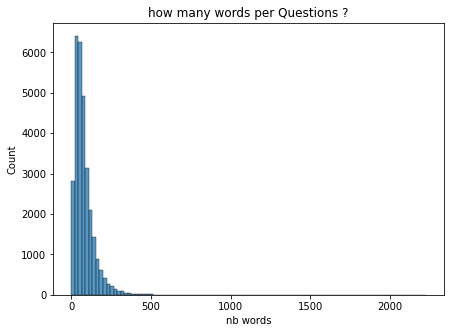

Average word count of questions is 80.7959 words per question


In [18]:
lengths = [len(question) for question in question_words]
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(lengths, bins = 100)

ax.set_xlabel('nb words')
ax.set_title('how many words per Questions ?')

plt.show()

print('Average word count of questions is %s' % np.mean(lengths), 'words per question')

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


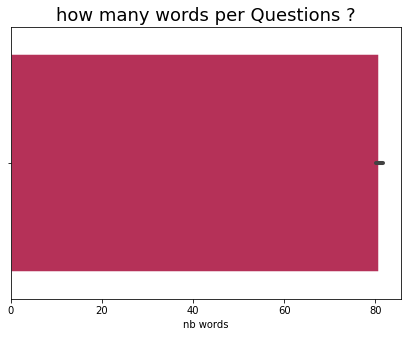

Average word count of questions is 80.7959 words per question


In [19]:
lengths = [len(question) for question in question_words]
fig, ax = plt.subplots(figsize=(7, 5))
sns.set_theme(style="white", context="talk")

sns.barplot(lengths, palette="rocket")

ax.set_xlabel('nb words')
ax.set_title('how many words per Questions ?')

plt.show()

print('Average word count of questions is %s' % np.mean(lengths), 'words per question')

# STOP WORDS

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stop_words = stopwords.words('english')

In [22]:
# Remove the stop words 
def remove_stopwords(sentences):
    filtered_words = [word for word in sentences if word not in stop_words]
    return filtered_words

In [23]:
filtered_questions = [remove_stopwords(question) for question in question_words]

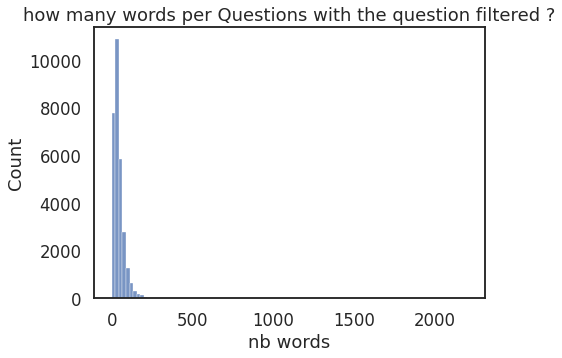

Average word count of questions is 43.86006666666667 words per question


In [24]:
lengths = [len(question) for question in filtered_questions]
fig, ax = plt.subplots(figsize=(7, 5))
sns.histplot(lengths, bins = 100)

ax.set_xlabel('nb words')
ax.set_title('how many words per Questions with the question filtered ?')

plt.show()

print('Average word count of questions is %s' % np.mean(lengths), 'words per question')

# WORD2VEC
--- 
## variables for WORD2VEC

In [25]:
size = 100
window = 10
epochs = 30

In [26]:
model_word2vec = Word2Vec(filtered_questions, size = size, window = window)

In [27]:
#Training model
model_word2vec.train(filtered_questions, total_examples=len(filtered_questions), epochs = epochs)

(34921208, 39474060)

# DOC2VEC
---
## variables for DOC2VEC

In [28]:
size = 100
window = 10
epochs = 30

In [29]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(filtered_questions)]
model = Doc2Vec(documents, vector_size = size, window = window, min_count = 5, workers = 2, dm = 1, epochs = epochs)

In [30]:
print(question_list[42], ' \n \n \n is similar to \n \n \n')

What's the best way to sanitise user input for a Python-based web application? Is there a single function to remove HTML characters and any other necessary characters combinations to prevent an XSS or SQL injection attack?  
 
 
 is similar to 
 
 



In [31]:
print([question_list[similar[0]] for similar in model.docvecs.most_similar(42)])

['Is there any way to monitor keyboard events in windows 7 with python without the python program having focus? I would like to run the python script as a background process that monitors certain keyboard events and does certain things on various keyboard input combinations.', 'How to escape HTML with characters like &#8211; in Python?', 'cgi.escape seems like one possible choice.  Does it work well?  Is there something that is considered better?', 'When I have a cursor, I know I can safely execute a query as follows: Is there any way to just get the string safely without executing the query? For example, if important_variable is a string, like "foo \'bar\' \\"baz", I\'d want the appropriately escaped one: (or whatever the appropriate escaping is, I\'m not even sure). I\'m using psycopg, and sqlobject.', 'and  a.html:', 'I am using Python version 2.5.4 and install MySQL version 5.0 and Django. Django is working fine with Python, but not MySQL. Can anyone help me to solve this issue? I 

In [ ]:
# © Axel CHENU 2021

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e80043e2-6875-4b65-a196-a0ffb97a1282' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>